In [165]:
import tweepy
import nltk
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize          
from nltk import WordNetLemmatizer 
from nltk.chunk import ne_chunk
from nltk.tokenize import MWETokenizer
from nltk.tag import pos_tag
import re
import string
import json
import requests
from pymongo import MongoClient
from pprint import pprint
from pymongo import InsertOne, DeleteOne, ReplaceOne
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt 

from gensim import corpora, models, similarities, matutils
from wordcloud import WordCloud, STOPWORDS

from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display


In [166]:
#Imports to for tokenizing tweets
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/lukevg2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukevg2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [167]:
from requests_oauthlib import OAuth1

In [168]:
#Keys to access twitter API and tweepy

#%load_ext dotenv
#%dotenv
import os

client_key = 'a1UoRUxbJz9A3QwFl0YqlrMec'
client_secret = 'Py59qGmdrDTjpaKkLRYBn0aKMPDha1AZPlnuN9jiWMLcQoKIXw'
resource_owner_key = '1128026401620332546-rIIzxGrJ9uwt7SoTQJ6iXA1cXavs5h'
resource_owner_secret = 'eVMMhlya13JKEsoXxBho4bNelF3nVQh02ExvVLcks2FXo'



oauth = OAuth1(client_key=client_key,
               client_secret=client_secret,
               resource_owner_key=resource_owner_key,
               resource_owner_secret=resource_owner_secret)

In [169]:
auth = tweepy.OAuthHandler(consumer_key=client_key,
                           consumer_secret=client_secret)
auth.set_access_token(resource_owner_key,
                      resource_owner_secret)

api=tweepy.API(auth)

#### Getting Streaming tweets

Tweets generated below are most recent from members of Congress

In [6]:
max_tweets = 10

for index, tweet in enumerate(tweepy.Cursor(api.search ,q="list:CSPAN/Members-of-Congress").items(max_tweets)):
    # You can see all the methods available on tweet using .<tab> or 
    # dir(tweet). You can access the raw JSON using tweet._json
    print(str(index) + '. ' + tweet.text + tweet.id_str + '\n')

0. This is more than just a humanitarian gesture—this is about honoring the courageous veterans and their families for… https://t.co/iA2h0gQOsN1131253710502412288

1. Proud to introduce the Filipino Veterans Family Reunification Act w/ @maziehirono to ensure the children of the Fil… https://t.co/thXBatnSjV1131253709026070531

2. During WWII, thousands of Filipinos put their lives on the line &amp; fought side-by-side w/ American soldiers under ou… https://t.co/IzGAXFNaXT1131253706622685184

3. Thank you to the Congressional @USArmy Liaison office for meeting with me and dropping off your seal! https://t.co/umANYzxpTt1131253647214555136

4. While Socialist Democrats advocate for giving illegal aliens government funded healthcare, I’m proud to say I just… https://t.co/Hbloy1kuja1131253470466646016

5. It was humbling to meet Hoosier veterans of World War II, the Korean War, the Vietnam War, and the Cold War during… https://t.co/3HLUIocvyT1131253467383771136

6. RT @BlazeTV: .@RepSeanDuff

In [ ]:
# getting user id's for each congress member to be able to pull tweets for all members
for user in api.list_members(owner_screen_name='CSPAN', slug='Members-of-Congress'):
    print(user.screen_name + " " + user.id_str)

In [ ]:
#print(api.list_members(owner_screen_name='CSPAN', slug='Members-of-Congress'))

In [68]:
# Get number of reTweets from Trump's account
congress.find({'text': {'$regex': 'RT @realDonaldTrump'}}).count()

/Applications/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  


434336

In [70]:
#look at retweets of Bernie Sanders and Alexandra Ocasio-Cortez for comparison
congress.find({'text': {'$regex': 'RT @SenSanders'}}).count()

/Applications/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


6959

In [71]:
congress.find({'text': {'$regex': 'RT @AOC'}}).count()

/Applications/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


2

#### Creating database for Politician Tweets

In [170]:
client = MongoClient()

In [171]:
db = client['politician_tweets']

In [172]:
congress = db['congress_members']

In [173]:
db.list_collection_names()

['governors', 'cabinet_members', 'congress_members']

In [174]:
#congress.find_one({})

#### Class to create Twitter stream listener and insert tweets into congress collection 

In [35]:
'''class MyStreamListener(tweepy.StreamListener):
    
    def __init__(self, collection):
        super(MyStreamListener, self).__init__()
        self.collection = collection
    
    
    def on_data(self, data):
        tweet = json.loads(data)
        #print(data)
        self.collection.insert_one(tweet)
        
    def processTweet(tweet):
        tweet_dict = {
        'datetime': tweet.created_at,
        'tweet': tweet.text,
        'entities': tweet.entities
    }
        #print(tweet_dict)
        return tweet_dict
        
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False'''

"class MyStreamListener(tweepy.StreamListener):\n    \n    def __init__(self, collection):\n        super(MyStreamListener, self).__init__()\n        self.collection = collection\n    \n    \n    def on_data(self, data):\n        tweet = json.loads(data)\n        #print(data)\n        self.collection.insert_one(tweet)\n        \n    def processTweet(tweet):\n        tweet_dict = {\n        'datetime': tweet.created_at,\n        'tweet': tweet.text,\n        'entities': tweet.entities\n    }\n        #print(tweet_dict)\n        return tweet_dict\n        \n    def on_error(self, status_code):\n        if status_code == 420:\n            #returning False in on_error disconnects the stream\n            return False"

Commenting out other listeners because using multiple listeners at at time overloaded computer. To avoid this, I 
combined the listeners and put tweets from all three lists into one MongoDB collection.


In [13]:
Political_Listener = MyStreamListener(congress)
#Cabinet_Listener = MyStreamListener(cabinet)
#Governors_Listener = MyStreamListener(governors)


In [14]:
Political_Stream = tweepy.Stream(auth = auth, listener=Political_Listener)
#Cabinet_Stream = tweepy.Stream(auth = auth, listener=Cabinet_Listener)
#Governors_Stream = tweepy.Stream(auth = auth, listener=Governors_Listener)

In [15]:
political_list = []
#cabinet_list = []
#governors_list = []
for member in tweepy.Cursor(api.list_members, 'CSPAN', 'Members-of-Congress').items():
    political_list.append(member.id_str)
for member in tweepy.Cursor(api.list_members, 'CSPAN', 'Governors').items():
    political_list.append(member.id_str)
for member in tweepy.Cursor(api.list_members, 'CSPAN', 'The-Cabinet').items():
    political_list.append(member.id_str)

In [34]:
print(len(political_list))
#print(len(governors_list))
#print(len(cabinet_list))

655


Cell below runs Twitter listener that collects politician's tweets. This cell will run until shutdown

In [100]:
#Political_Stream.filter(follow=political_list)

In [10]:
congress_count = congress.count_documents({})
congress_count

1533011

Create dataframe for all tweets with just ID columns and the text of each tweet

In [315]:
tweet_df = pd.DataFrame(list(congress.find({}, {'_id': 1, 'text': 1, 'id_str': 1})))

Take random sample of all tweets since running a model on the full data set takes a long time to run.

In [ ]:
tweet_df = tweet_df.sample(frac=0.01, replace=False, random_state=11)

In [178]:
tweet_df.shape

(15330, 3)

In [179]:
tweet_df.head()

,_id,id_str,text
549412,5ce0aada5c26034ffe0b8606,1129914855916335104,@LindseyGrahamSC Don’t trust anything just ano...
1212317,5ce53eb95c260305f1ab6579,1131173141131223040,@realDonaldTrump Congress has passed several b...
1388726,5ce56d3e5c260305f1ae1693,1131223095845490689,RT @realDonaldTrump: As I have long been sayin...
286137,5ce063515c26034ffe07819b,1129838045946105857,RT @SteveScalise: Nancy Pelosi is blocking cri...
249896,5cdf53db5c26034b3a08f8a2,1129546552912023553,@RepAndyBiggsAZ @RepMattGaetz Time to resign a...


In [180]:
tweets = tweet_df.text
type(tweets)

pandas.core.series.Series

## Modeling

Class to clean, tokenize, lemmatize, and prepare tweets for modeling

In [182]:
class nlp_preprocessor:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None, model=None):
        """
        A class for pipelining our data in NLP problems. The user provides a series of 
        tools, and this class manages all of the training, transforming, and modification
        of the text data.
        ---
        Inputs:
        vectorizer: the model to use for vectorization of text data
        tokenizer: The tokenizer to use, if none defaults to split on spaces
        cleaning_function: how to clean the data, if None, defaults to the in built class
        """
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        """
        Default tokenizer that splits on spaces naively
        """
        return text.split(' ')
        
    def clean_text(self, text, tokenizer, lemmatizer):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if lemmatizer:
                    low_word = lemmatizer.lemmatize(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text
    
    def fit(self, text):
        """
        Cleans the data and then fits the vectorizer with
        the user provided text
        """
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer )
        self.vectorizer.fit(clean_text)
        self._is_fit = True
        
    def transform(self, text):
        """
        Cleans any provided data and then transforms the data into
        a vectorized format based on the fit function. Returns the
        vectorized form of the data.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.transform(clean_text)
    
    def save_pipe(self, filename):
        """
        Writes the attributes of the pipeline to a file
        allowing a pipeline to be loaded later with the
        pre-trained pieces in place.
        """
        if type(filename) != str:
            raise TypeError("filename must be a string")
        pickle.dump(self.__dict__, open(filename+".mdl",'wb'))
        
    def load_pipe(self, filename):
        """
        Writes the attributes of the pipeline to a file
        allowing a pipeline to be loaded later with the
        pre-trained pieces in place.
        """
        if type(filename) != str:
            raise TypeError("filename must be a string")
        if filename[-4:] != '.mdl':
            filename += '.mdl'
        self.__dict__ = pickle.load(open(filename,'rb'))

In [183]:
tweets = list(tweets)

In [184]:
text_data = np.array(tweets)

#### LSA Count Vectorizer

In [273]:
stopwords = nltk.corpus.stopwords.words('english')
more_stop_words = ['https', 'http', 'trump', '@', 'rt', 'wa', 'like', 'ha', 'co']
stopwords.extend(more_stop_words)
len(stopwords)

188

In [199]:
cloud_stopwords = list(stopwords)

In [200]:
nlp = nlp_preprocessor(vectorizer=CountVectorizer(stop_words=stopwords, min_df = .03, max_df = .8),
                       tokenizer=TreebankWordTokenizer().tokenize, lemmatizer=WordNetLemmatizer())

In [201]:
nlp.fit(text_data)
topic_words = nlp.transform(text_data)
topic_words.shape

(15330, 27)

In [202]:
pd.DataFrame(topic_words.toarray(), index=text_data, columns=nlp.vectorizer.get_feature_names()).head(10)
print(nlp.vectorizer.get_feature_names())

['american', 'amp', 'attorney', 'barr', 'conclusion', 'congress', 'country', 'deliberately', 'democrat', 'foxnews', 'general', 'great', 'iran', 'justinamash', 'misrepresented', 'mueller', 'never', 'people', 'president', 'principal', 'report', 'republican', 'state', 'today', 'united', 'want', 'would']


In [203]:
lsa = TruncatedSVD(3) #number of topics in parentheses
doc_topic = lsa.fit_transform(topic_words)
lsa.explained_variance_ratio_

array([0.3046279 , 0.11762574, 0.06412664])

In [204]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,people,president,principal,report,republican,state,today,united,want,would
component_1,0.008,0.003,0.248,0.319,0.276,0.033,0.005,0.236,0.018,0.001,...,0.004,0.293,0.258,0.364,0.006,0.005,0.011,0.002,0.003,0.006
component_2,0.029,0.021,-0.005,-0.007,-0.010,0.014,0.071,-0.004,0.038,0.003,...,0.048,0.020,-0.009,-0.008,0.019,0.350,0.004,0.333,0.404,0.008
component_3,0.032,0.354,-0.129,-0.103,-0.077,0.369,0.666,-0.122,0.198,0.004,...,0.114,-0.103,-0.106,0.120,0.050,-0.003,0.020,-0.007,-0.040,0.023


In [205]:
topic_word.columns

Index(['american', 'amp', 'attorney', 'barr', 'conclusion', 'congress',
       'country', 'deliberately', 'democrat', 'foxnews', 'general', 'great',
       'iran', 'justinamash', 'misrepresented', 'mueller', 'never', 'people',
       'president', 'principal', 'report', 'republican', 'state', 'today',
       'united', 'want', 'would'],
      dtype='object')

Function to display topics generated by each of type of topic model

In [206]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [207]:
display_topics(lsa, nlp.vectorizer.get_feature_names(), 5)


Topic  0
justinamash, mueller, report, barr, president

Topic  1
iran, want, state, united, never

Topic  2
country, congress, amp, justinamash, democrat


Matrix below maps features to topics

In [255]:
Vt = pd.DataFrame(doc_topic.round(4),
             index = text_data,
             columns = ["component_1","component_2", "component_3"])

Vt

Assign an overall topic to each tweet for T-SNE distribution. All steps followed in this model will be followed in the subsequent models.

Vt_matrix = Vt.idxmax(axis = 1, skipna = True)

#### LSA - TFIDF

In [210]:
tfidf_nlp = nlp_preprocessor(vectorizer=TfidfVectorizer(stop_words=stopwords, min_df = .03, max_df = .8),
                       tokenizer=TreebankWordTokenizer().tokenize, lemmatizer=WordNetLemmatizer())

In [211]:
tfidf_nlp.fit(text_data)
tfidf_filtered_words = tfidf_nlp.transform(text_data)
tfidf_filtered_words.shape

(15330, 27)

Get most used words in all tweets collected.

In [212]:
pd.DataFrame(tfidf_filtered_words.toarray(), index=text_data, columns=tfidf_nlp.vectorizer.get_feature_names()).head(10)
print(tfidf_nlp.vectorizer.get_feature_names())

['american', 'amp', 'attorney', 'barr', 'conclusion', 'congress', 'country', 'deliberately', 'democrat', 'foxnews', 'general', 'great', 'iran', 'justinamash', 'misrepresented', 'mueller', 'never', 'people', 'president', 'principal', 'report', 'republican', 'state', 'today', 'united', 'want', 'would']


In [213]:
tfidf_lsa = TruncatedSVD(3) #2is the number of topics we want
doc_topic = tfidf_lsa.fit_transform(tfidf_filtered_words)
tfidf_lsa.explained_variance_ratio_

array([0.11707447, 0.07642559, 0.06752818])

In [214]:
topic_word = pd.DataFrame(tfidf_lsa.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = tfidf_nlp.vectorizer.get_feature_names())
topic_word

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,people,president,principal,report,republican,state,today,united,want,would
component_1,0.026,0.014,0.110,0.212,0.153,0.084,0.025,0.104,0.047,0.003,...,0.017,0.230,0.124,0.274,0.025,0.010,0.015,0.005,0.009,0.019
component_2,0.111,0.071,0.162,0.225,0.170,0.074,0.124,0.146,0.217,0.018,...,0.070,0.333,0.157,0.310,-0.001,0.048,0.060,0.037,0.065,0.068
component_3,0.065,0.116,-0.058,-0.092,-0.072,0.032,0.224,-0.054,0.086,0.017,...,0.100,-0.001,-0.063,-0.117,0.198,0.091,0.094,0.058,0.077,0.165


In [215]:
topic_word.columns

Index(['american', 'amp', 'attorney', 'barr', 'conclusion', 'congress',
       'country', 'deliberately', 'democrat', 'foxnews', 'general', 'great',
       'iran', 'justinamash', 'misrepresented', 'mueller', 'never', 'people',
       'president', 'principal', 'report', 'republican', 'state', 'today',
       'united', 'want', 'would'],
      dtype='object')

In [216]:
display_topics(tfidf_lsa, tfidf_nlp.vectorizer.get_feature_names(), 4)



Topic  0
justinamash, mueller, report, president

Topic  1
mueller, president, report, barr

Topic  2
great, country, republican, would


In [217]:
Vt = pd.DataFrame(doc_topic.round(4),
             index = text_data,
             columns = ["component_1","component_2","component_3"])
Vt

,component_1,component_2,component_3
@LindseyGrahamSC Don’t trust anything just another lie that got us into war,0.00000,-0.00000,0.00000
@realDonaldTrump Congress has passed several bills that now sit with the Senate. However Mitch McConnel refuses t… https://t.co/ZiHWPibzta,0.08379,0.07044,0.03466
"RT @realDonaldTrump: As I have long been saying, and has now been proven out, this is a Witch Hunt against the Republican Party and myself,…",0.02502,-0.00225,0.20174
RT @SteveScalise: Nancy Pelosi is blocking critical legislation to combat the dangerous BDS movement from receiving a vote in the House. To…,-0.00000,0.00000,0.00000
@RepAndyBiggsAZ @RepMattGaetz Time to resign asshole! \nhttps://t.co/ssasdalWDe,0.00000,0.00000,-0.00000
"@realDonaldTrump No, Trump is the problem, The majority of the country who didn't vote for him knew he would be a p… https://t.co/5uRaKga1Xg",0.03102,0.13355,0.27125
@realDonaldTrump You can't keep your anger in check when Nancy said you were engaged in a cover-up and you storm of… https://t.co/UT8osLCgcN,0.00000,-0.00000,0.00000
"RT @realDonaldTrump: If Iran wants to fight, that will be the official end of Iran. Never threaten the United States again!",0.02199,0.12029,0.20077
"@justinamash stopped at that point. It just would have been in someone else’s hands. Which, as we see now, it shoul… https://t.co/kO5FMBc9Zp",0.46319,-0.25935,0.18856
@SenTedCruz Wtf,-0.00000,0.00000,-0.00000


#### LSA Count vectorizer gives much more distinct topics and explains a higher percentage of variance than LSA TFIDF 

#### NMF Count Vectorizer

In [219]:
nmf_nlp = nlp_preprocessor(vectorizer=CountVectorizer(stop_words=stopwords, min_df = .03, max_df = .8),
                       tokenizer=TreebankWordTokenizer().tokenize, lemmatizer=WordNetLemmatizer())

In [220]:
nmf_nlp.fit(text_data)
nmf_words = nmf_nlp.transform(text_data)
nmf_words.shape

(15330, 27)

In [221]:
pd.DataFrame(nmf_words.toarray(), index=text_data, columns=nmf_nlp.vectorizer.get_feature_names()).sample(5)

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,people,president,principal,report,republican,state,today,united,want,would
"RT @realDonaldTrump: Everything the Democrats are asking me for is based on an illegally started investigation that failed for them, especi…",0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
@PatrickMcHenry https://t.co/M4ReR4ss2k,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@TheJusticeDept https://t.co/wSnroiwwNV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"RT @realDonaldTrump: Today, it was my great honor to address the the National Association of REALTORS! https://t.co/LQNExa57ne",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
"RT @RepSpeier: Today, I shared my story of my 2nd trimester abortion, a painful procedure that became necessary after the fetus I was carry…",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [222]:
nmf_model = NMF(2)
nmf_topic = nmf_model.fit_transform(nmf_words)

In [223]:
nmf_topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2"],
             columns = nmf_nlp.vectorizer.get_feature_names())
nmf_topic_word

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,people,president,principal,report,republican,state,today,united,want,would
component_1,0.071,0.025,2.329,3.0,2.598,0.308,0.037,2.218,0.163,0.007,...,0.035,2.756,2.425,3.422,0.053,0.011,0.104,0.000,0.000,0.052
component_2,0.211,0.153,0.000,0.0,0.000,0.098,0.515,0.000,0.275,0.021,...,0.346,0.153,0.000,0.000,0.138,2.553,0.030,2.427,2.948,0.056


In [224]:
display_topics(nmf_model, nmf_nlp.vectorizer.get_feature_names(), 4)


Topic  0
justinamash, mueller, report, barr

Topic  1
iran, want, state, united


In [225]:
H = pd.DataFrame(nmf_topic.round(5),
             index = text_data,
             columns = ["component_1","component_2" ])
H

,component_1,component_2
@LindseyGrahamSC Don’t trust anything just another lie that got us into war,0.00000,0.00000
@realDonaldTrump Congress has passed several bills that now sit with the Senate. However Mitch McConnel refuses t… https://t.co/ZiHWPibzta,0.00347,0.00180
"RT @realDonaldTrump: As I have long been saying, and has now been proven out, this is a Witch Hunt against the Republican Party and myself,…",0.00058,0.00259
RT @SteveScalise: Nancy Pelosi is blocking critical legislation to combat the dangerous BDS movement from receiving a vote in the House. To…,0.00000,0.00000
@RepAndyBiggsAZ @RepMattGaetz Time to resign asshole! \nhttps://t.co/ssasdalWDe,0.00000,0.00000
"@realDonaldTrump No, Trump is the problem, The majority of the country who didn't vote for him knew he would be a p… https://t.co/5uRaKga1Xg",0.00091,0.01072
@realDonaldTrump You can't keep your anger in check when Nancy said you were engaged in a cover-up and you storm of… https://t.co/UT8osLCgcN,0.00000,0.00000
"RT @realDonaldTrump: If Iran wants to fight, that will be the official end of Iran. Never threaten the United States again!",0.00000,0.38493
"@justinamash stopped at that point. It just would have been in someone else’s hands. Which, as we see now, it shoul… https://t.co/kO5FMBc9Zp",0.04352,0.00106
@SenTedCruz Wtf,0.00000,0.00000


#### NMF - TDIDF

In [282]:
nmf_tfidf = nlp_preprocessor(vectorizer=TfidfVectorizer(stop_words=stopwords, min_df = .03, max_df = .8),
                       tokenizer=TreebankWordTokenizer().tokenize, lemmatizer=WordNetLemmatizer())

In [283]:
nmf_tfidf.fit(text_data)
nmf_tfidf_words = nmf_tfidf.transform(text_data)
nmf_tfidf_words.shape

(15330, 28)

In [284]:
pd.DataFrame(nmf_tfidf_words.toarray(), index=text_data, columns=nmf_tfidf.vectorizer.get_feature_names()).sample(5)

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,president,principal,realdonaldtrump,report,republican,state,today,united,want,would
RT @SenKamalaHarris: #FBF to when I asked Brett Kavanaugh: Can you think of any laws that give the government the power to make decisions a…,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"RT @realDonaldTrump: The Democrats are on a fishing expedition, wanting to interview the same people, and see the same things, as we just w…",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.657691,0.0,...,0.0,0.0,0.270647,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"RT @RepDanCrenshaw: We voted on this bill, the Strengthening Health Care and Lowering Prescription Drug Costs Act, last night. #Heresthetru…",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@realDonaldTrump https://t.co/9F9OUokvm1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
@realDonaldTrump YOU are bad for the country. Your lies and misdeeds have embarrassed us and are fostering a civil… https://t.co/bJbimzlV46,0.0,0.0,0.0,0.0,0.0,0.0,0.925232,0.0,0.000000,0.0,...,0.0,0.0,0.379403,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
nmf_tfidf_model = NMF(3)
nmf_tfidf_topic = nmf_tfidf_model.fit_transform(nmf_tfidf_words)

In [286]:
nmf_tfidf_word = pd.DataFrame(nmf_tfidf_model.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = nmf_tfidf.vectorizer.get_feature_names())
nmf_tfidf_word

,american,amp,attorney,barr,conclusion,congress,country,deliberately,democrat,foxnews,...,president,principal,realdonaldtrump,report,republican,state,today,united,want,would
component_1,0.082,0.144,0.000,0.000,0.000,0.046,0.259,0.000,0.245,0.306,...,0.106,0.000,8.012,0.000,0.154,0.082,0.031,0.103,0.138,0.178
component_2,0.000,0.010,0.000,0.109,0.058,0.232,0.061,0.000,0.000,0.000,...,0.001,0.000,0.000,0.125,0.204,0.001,0.000,0.000,0.000,0.000
component_3,0.300,0.068,1.091,1.776,1.309,0.449,0.079,1.008,0.511,0.000,...,1.975,1.144,0.000,2.259,0.000,0.070,0.187,0.029,0.068,0.132


In [287]:
display_topics(nmf_tfidf_model, nmf_tfidf.vectorizer.get_feature_names(), 4)


Topic  0
realdonaldtrump, great, foxnews, country

Topic  1
justinamash, congress, republican, report

Topic  2
mueller, report, president, barr


In [289]:
H = pd.DataFrame(nmf_tfidf_topic.round(5),
             index = text_data,
             columns = ["component_1","component_2", "component_3" ])
H.sample(10)

,component_1,component_2,component_3
"RT @justinamash: In comparing Barr’s principal conclusions, congressional testimony, and other statements to Mueller’s report, it is clear…",0.00000,0.05379,0.13758
@realDonaldTrump I honestly thought this was a parody account. I have to double-check all the time now,0.12355,0.00000,0.00000
@realDonaldTrump it’s time to show the American people the real facts the truth declassify Now let the cards fall w… https://t.co/eKUhAtqL2t,0.03513,0.00000,0.00949
RT @realDonaldTrump: Much of the Wall being built at the Southern Border is a complete demolition and rebuilding of old and worthless barri…,0.12355,0.00000,0.00000
RT @SenKamalaHarris: Make no mistake: foreign adversaries are preparing to meddle in our upcoming elections. That's why I joined @RonWyden…,0.00000,0.00000,0.00000
"RT @realDonaldTrump: ....Federal Judges (many more to come), two great new Supreme Court Justices, the Mexico City Policy, and a whole new…",0.05470,0.00221,0.00000
@realDonaldTrump @FoxNews https://t.co/ne8AWOSppF,0.04679,0.00000,0.00000
"RT @realDonaldTrump: As I have long been saying, and has now been proven out, this is a Witch Hunt against the Republican Party and myself,…",0.04433,0.00485,0.00000
RT @realDonaldTrump: My Campaign for President was conclusively spied on. Nothing like this has ever happened in American Politics. A reall…,0.03711,0.00000,0.05244
@realDonaldTrump https://t.co/BbezlGi0sb,0.12355,0.00000,0.00000


In [290]:
H_matrix = H.idxmax(axis = 1, skipna = True)

In [303]:
H_matrix[28]

'component_3'

#### LDA Count Vectorizer

In [238]:
lda_countvectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=stopwords, analyzer='word', token_pattern="\\b[a-z][a-z]+\\b")

In [239]:
lda_countvectorizer.fit(text_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...uldn', "wouldn't", 'https', 'http', 'trump', '@', 'realdonaldtrump', 'rt', 'wa', 'like', 'ha', 'co'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [240]:
lda_doc_word = lda_countvectorizer.transform(text_data).transpose()

In [241]:
pd.DataFrame(lda_doc_word.toarray(), lda_countvectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329
ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned almost,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoning rest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [242]:
lda_doc_word.shape

(47048, 15330)

In [243]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(lda_doc_word)

##### Map matrix rows to words (tokens)
We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [244]:
id2word = dict((v, k) for k, v in lda_countvectorizer.vocabulary_.items())

In [245]:
len(id2word)

47048

###  Creating LDA models

In [42]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, passes=5)

2019-05-22 19:43:17,739 : INFO : using symmetric alpha at 0.5
2019-05-22 19:43:17,741 : INFO : using symmetric eta at 0.5
2019-05-22 19:43:17,753 : INFO : using serial LDA version on this node
2019-05-22 19:43:17,768 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 15330 documents, updating model once every 2000 documents, evaluating perplexity every 15330 documents, iterating 50x with a convergence threshold of 0.001000
2019-05-22 19:43:17,802 : INFO : PROGRESS: pass 0, at document #2000/15330
2019-05-22 19:43:21,013 : INFO : merging changes from 2000 documents into a model of 15330 documents
2019-05-22 19:43:21,026 : INFO : topic #0 (0.500): 0.006*"justinamash" + 0.006*"mueller" + 0.006*"president" + 0.005*"report" + 0.005*"great" + 0.005*"mueller report" + 0.005*"barr" + 0.004*"iran" + 0.004*"general" + 0.003*"country"
2019-05-22 19:43:21,029 : INFO : topic #1 (0.500): 0.009*"justinamash" + 0.004*"report" + 0.004*"mueller" + 0.004*"ba

2019-05-22 19:43:34,552 : INFO : topic diff=0.381048, rho=0.321661
2019-05-22 19:43:34,590 : INFO : PROGRESS: pass 1, at document #8000/15330
2019-05-22 19:43:35,768 : INFO : merging changes from 2000 documents into a model of 15330 documents
2019-05-22 19:43:35,781 : INFO : topic #0 (0.500): 0.010*"justinamash" + 0.009*"president" + 0.007*"mueller" + 0.006*"report" + 0.006*"barr" + 0.006*"iran" + 0.006*"mueller report" + 0.006*"great" + 0.005*"general" + 0.005*"country"
2019-05-22 19:43:35,783 : INFO : topic #1 (0.500): 0.006*"justinamash" + 0.003*"mueller" + 0.003*"democrats" + 0.003*"report" + 0.003*"foxnews" + 0.002*"read" + 0.002*"mr" + 0.002*"think" + 0.002*"people" + 0.002*"one"
2019-05-22 19:43:35,785 : INFO : topic diff=0.364402, rho=0.321661
2019-05-22 19:43:35,818 : INFO : PROGRESS: pass 1, at document #10000/15330
2019-05-22 19:43:36,680 : INFO : merging changes from 2000 documents into a model of 15330 documents
2019-05-22 19:43:36,695 : INFO : topic #0 (0.500): 0.010*"jus

2019-05-22 19:43:45,456 : INFO : topic #1 (0.500): 0.005*"justinamash" + 0.003*"mueller" + 0.003*"report" + 0.003*"democrats" + 0.003*"read" + 0.003*"foxnews" + 0.002*"mr" + 0.002*"people" + 0.002*"us" + 0.002*"mayor"
2019-05-22 19:43:45,458 : INFO : topic diff=0.330920, rho=0.306210
2019-05-22 19:43:46,422 : INFO : -9.138 per-word bound, 563.6 perplexity estimate based on a held-out corpus of 1330 documents with 22020 words
2019-05-22 19:43:46,423 : INFO : PROGRESS: pass 2, at document #15330/15330
2019-05-22 19:43:46,898 : INFO : merging changes from 1330 documents into a model of 15330 documents
2019-05-22 19:43:46,915 : INFO : topic #0 (0.500): 0.011*"justinamash" + 0.009*"president" + 0.007*"mueller" + 0.007*"barr" + 0.006*"report" + 0.006*"iran" + 0.006*"great" + 0.006*"mueller report" + 0.005*"general" + 0.005*"country"
2019-05-22 19:43:46,918 : INFO : topic #1 (0.500): 0.006*"justinamash" + 0.003*"mueller" + 0.003*"report" + 0.003*"democrats" + 0.003*"foxnews" + 0.003*"read" + 

2019-05-22 19:43:55,306 : INFO : PROGRESS: pass 4, at document #6000/15330
2019-05-22 19:43:55,996 : INFO : merging changes from 2000 documents into a model of 15330 documents
2019-05-22 19:43:56,010 : INFO : topic #0 (0.500): 0.010*"justinamash" + 0.009*"president" + 0.007*"mueller" + 0.007*"report" + 0.007*"mueller report" + 0.007*"barr" + 0.006*"iran" + 0.006*"great" + 0.005*"general" + 0.005*"country"
2019-05-22 19:43:56,013 : INFO : topic #1 (0.500): 0.005*"justinamash" + 0.003*"mueller" + 0.003*"report" + 0.003*"democrats" + 0.003*"foxnews" + 0.003*"read" + 0.002*"mr" + 0.002*"people" + 0.002*"think" + 0.002*"mayor"
2019-05-22 19:43:56,015 : INFO : topic diff=0.295534, rho=0.280994
2019-05-22 19:43:56,049 : INFO : PROGRESS: pass 4, at document #8000/15330
2019-05-22 19:43:56,728 : INFO : merging changes from 2000 documents into a model of 15330 documents
2019-05-22 19:43:56,742 : INFO : topic #0 (0.500): 0.010*"justinamash" + 0.009*"president" + 0.007*"mueller" + 0.007*"barr" + 0

Most important words for each of the 2 topics. 3 topics results in two topics that are virtually identical.

In [43]:
lda.print_topics()

2019-05-22 19:44:00,418 : INFO : topic #0 (0.500): 0.011*"justinamash" + 0.008*"president" + 0.007*"mueller" + 0.007*"barr" + 0.007*"report" + 0.006*"iran" + 0.006*"great" + 0.006*"mueller report" + 0.005*"general" + 0.005*"country"
2019-05-22 19:44:00,422 : INFO : topic #1 (0.500): 0.006*"justinamash" + 0.003*"mueller" + 0.003*"report" + 0.003*"democrats" + 0.003*"foxnews" + 0.003*"read" + 0.002*"mr" + 0.002*"people" + 0.002*"american" + 0.002*"mayor"


[(0,
  '0.011*"justinamash" + 0.008*"president" + 0.007*"mueller" + 0.007*"barr" + 0.007*"report" + 0.006*"iran" + 0.006*"great" + 0.006*"mueller report" + 0.005*"general" + 0.005*"country"'),
 (1,
  '0.006*"justinamash" + 0.003*"mueller" + 0.003*"report" + 0.003*"democrats" + 0.003*"foxnews" + 0.003*"read" + 0.002*"mr" + 0.002*"people" + 0.002*"american" + 0.002*"mayor"')]

In [44]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [45]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

Now we can take a look at the document vectors in the topic space, which are measures of the component of each document along each topic.  Thus, at most a document vector can have num_topics=3 nonzero components in the topic space, and most have far fewer.

In [47]:
# Check out the document vectors in the topic space for the first 10 documents
lda_docs[0:9]

[[(0, 0.0397368), (1, 0.96026325)],
 [(0, 0.18753265), (1, 0.81246734)],
 [(0, 0.03832138), (1, 0.9616786)],
 [(0, 0.057966456), (1, 0.9420335)],
 [(0, 0.051442012), (1, 0.94855803)],
 [(0, 0.081759244), (1, 0.9182408)],
 [(0, 0.21059388), (1, 0.7894061)],
 [(0, 0.97469884), (1, 0.025301164)],
 [(0, 0.033061996), (1, 0.966938)]]

### Visualizations

Create word cloud of most popular words from the 1.5M tweets collected. Some words associated with Trump removed so variations of his name do not appear over and over.

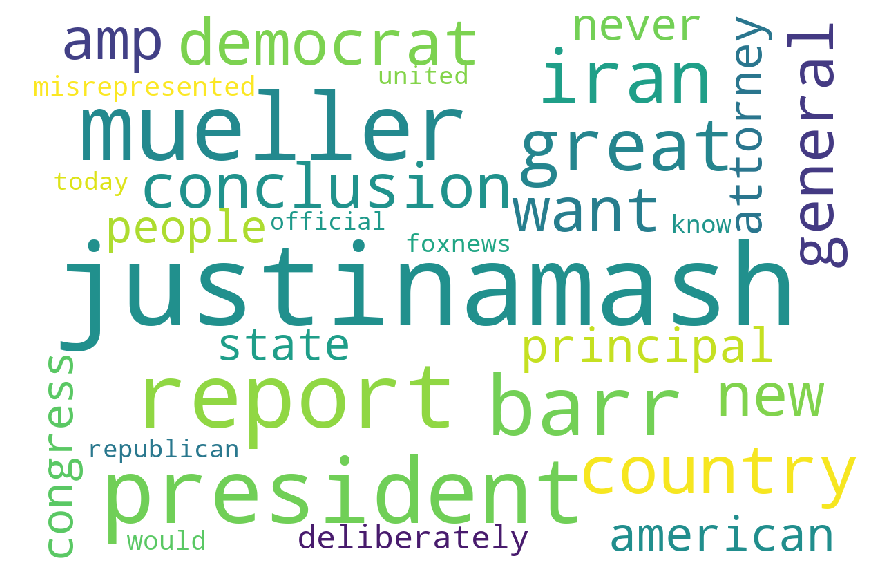

In [318]:
cloud_words = ' '
  
# iterate through tweets
for val in tweet_df.text: 
      
    # convert each tweet to string 
    val = str(val) 
    #print(val)  
    
    tokens = val.split() 
    #print(tokens)  
    
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for word in tokens: 
        #print(word)
        cloud_words = cloud_words + word + ' '
        
  
wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white',
                max_words=30,
                collocations=False,
                stopwords = cloud_stopwords, 
                min_font_size = 12).generate(cloud_words) 
  
# plot WordCloud image                        
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


Visualizing Topic Differences with T-SNE Distrubution

In [99]:
from sklearn.manifold import TSNE

In [292]:
vectors = TfidfVectorizer().fit_transform(H_matrix)
X_reduced = TruncatedSVD(n_components=2, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15330 samples in 0.145s...
[t-SNE] Computed neighbors for 15330 samples in 1.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15330
[t-SNE] Computed conditional probabilities for sample 2000 / 15330
[t-SNE] Computed conditional probabilities for sample 3000 / 15330
[t-SNE] Computed conditional probabilities for sample 4000 / 15330
[t-SNE] Computed conditional probabilities for sample 5000 / 15330
[t-SNE] Computed conditional probabilities for sample 6000 / 15330
[t-SNE] Computed conditional probabilities for sample 7000 / 15330
[t-SNE] Computed conditional probabilities for sample 8000 / 15330
[t-SNE] Computed conditional probabilities for sample 9000 / 15330
[t-SNE] Computed conditional probabilities for sample 10000 / 15330
[t-SNE] Computed conditional probabilities for sample 11000 / 15330
[t-SNE] Computed conditional probabilities for sample 12000 / 15330
[t-SNE] Computed conditional probabilities for sa

In [309]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize the text
tfidf  = TfidfVectorizer()
topic_vectors = tfidf.fit_transform(text_data)

In [311]:
labels = H_matrix

2019-05-24 05:46:50,376 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-05-24 05:46:50,424 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-05-24 05:46:50,470 : WARNING : 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


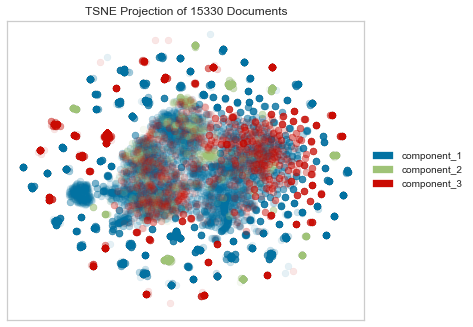

In [314]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(alpha = 0.1)
tsne.fit(topic_vectors, labels)
tsne.poof()

T-SNE Distribution shows little separation of topics.